# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

transformers.__version__

'4.30.1'

# Dataset

In [3]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    '../.ds/model-starchat-beta_ds-amazon-polarity_format-guard-prompt_N200_3shots_5cc9f5'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets([load_from_disk(f) for f in fs])
ds

Dataset({
    features: ['hs0', 'scores0', 'hs1', 'scores1', 'true', 'index', 'label', 'prompt', 'lie', 'prompt_truncated', 'choice_probs0', 'ans0', 'choice_probs1', 'ans1', 'txt_ans0', 'txt_ans1'],
    num_rows: 200
})

In [4]:
from src.datasets.load import ds2df

## Filter

In [5]:
# lets select only the ones where
df = ds2df(ds)
df

,true,index,label,prompt,lie,prompt_truncated,choice_probs0,ans0,choice_probs1,ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,desired_ans
0,1,0,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.078145705, 0.32699254]",0.807094,"[0.1094421, 0.48459822]",0.815753,True,True,0.008659,0.008659,0.811423,True,False
1,0,1,1,<|system|>You are about to immerse yourself in...,True,. You take a role from the classic puzzle of t...,"[0.60891825, 0.33895335]",0.357590,"[0.18620293, 0.22872218]",0.551224,False,True,0.193634,0.193634,0.454407,False,False
2,1,2,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.22698066, 0.34947497]",0.606237,"[0.34118584, 0.5306288]",0.608642,True,True,0.002404,0.002404,0.607440,True,True
3,0,3,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.57587034, 0.24939153]",0.302193,"[0.46418592, 0.23797682]",0.338915,False,False,0.036722,0.036722,0.320554,False,False
4,1,4,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.31092325, 0.34889498]",0.528766,"[0.42988867, 0.47642803]",0.525669,True,True,-0.003097,0.003097,0.527218,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,195,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.4364484, 0.41708928]",0.488654,"[0.44443354, 0.41476423]",0.482729,False,False,-0.005925,0.005925,0.485691,False,False
196,1,196,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.22973666, 0.21817155]",0.487079,"[0.3398598, 0.32811356]",0.491200,False,False,0.004121,0.004121,0.489140,False,True
197,1,197,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.35407448, 0.24763522]",0.411546,"[0.2403055, 0.13180408]",0.354198,False,False,-0.057348,0.057348,0.382872,False,True
198,0,198,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.4638396, 0.23526415]",0.336518,"[0.23999612, 0.32018945]",0.571567,False,True,0.235050,0.235050,0.454042,False,True


In [6]:


# # just select the question where the model knows the answer. 
# d = df.query('version=="truth"').set_index("index")
# # these are the ones where it got it right when asked to tell the truth
# known_indices = d[d.llm_ans==d.true_answer].index

# # convert to row numbers, and use datasets to select
# known_rows = df['index'].isin(known_indices)
# known_rows_i = df[known_rows].index

# # also restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
# m = np.abs(df.ans1-df.ans2)>0.10
# significant_rows = m[m].index

# allowed_rows_i = set(known_rows_i).intersection(significant_rows)
# ds = ds1.select(allowed_rows_i)
# ds

## Transform: Normalize by activation

In [7]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs1 = small_ds['hs1'].reshape((b, -1))

# scaler = RobustScaler()
# hs2 = scaler.fit_transform(hs1)

# def normalize_hs(hs1, hs2):
#     b = len(hs1)
#     hs1 = scaler.transform(hs1.reshape((b, -1)))
#     hs2 = scaler.transform(hs2.reshape((b, -1)))
#     return {'hs1':hs1, 'hs2': hs2}

# # # Plot
# # plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# # plt.hist(hs2.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# # plt.legend()
# # plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs1', 'hs2'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs1', 'hs2'])
# ds

## Lightning DataModule

In [8]:
df = ds2df(ds)
df.head(4)

,true,index,label,prompt,lie,prompt_truncated,choice_probs0,ans0,choice_probs1,ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,desired_ans
0,1,0,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.078145705, 0.32699254]",0.807094,"[0.1094421, 0.48459822]",0.815753,True,True,0.008659,0.008659,0.811423,True,False
1,0,1,1,<|system|>You are about to immerse yourself in...,True,. You take a role from the classic puzzle of t...,"[0.60891825, 0.33895335]",0.357590,"[0.18620293, 0.22872218]",0.551224,False,True,0.193634,0.193634,0.454407,False,False
2,1,2,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.22698066, 0.34947497]",0.606237,"[0.34118584, 0.5306288]",0.608642,True,True,0.002404,0.002404,0.607440,True,True
3,0,3,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.57587034, 0.24939153]",0.302193,"[0.46418592, 0.23797682]",0.338915,False,False,0.036722,0.036722,0.320554,False,False


What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- it was asked to lie
- it knows the truth
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [9]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule

In [38]:
batch_size = 12
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
len(dl_train), len(dl_val)

Loading cached shuffled indices for dataset at /home/ubuntu/Documents/mjc/elk/discovering_latent_knowledge/.ds/model-starchat-beta_ds-amazon-polarity_format-guard-prompt_N200_3shots_5cc9f5/cache-6c384d2ed06ed9ea.arrow


(8, 4)

In [39]:
b = next(iter(dl_train))
x0, x1, y = b
x0.shape

torch.Size([12, 6144, 37])

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [40]:
# dm.y

In [41]:
# n = len(df)

# # Define X and y
# X = dm.hs1-dm.hs2
# y = dm.y>0

# # split
# n = len(y)
# max_rows = 1000
# print('split size', n//2)
# X_train, X_test = X[:n//2], X[n//2:]
# y_train, y_test = y[:n//2], y[n//2:]
# X_train = X_train[:max_rows]
# y_train = y_train[:max_rows]
# X_test = X_test[:max_rows]
# y_test = y_test[:max_rows]

# # scale
# scaler = RobustScaler()
# scaler.fit(X_train)
# X_train2 = scaler.transform(X_train)
# X_test2 = scaler.transform(X_test)
# print('lr')

# lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=380)
# lr.fit(X_train2, y_train>0)

In [42]:
# print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
# print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

# m = df['lie'][n//2:][:max_rows]
# y_test_pred = lr.predict(X_test2)
# acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
# acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
# print(f'test acc w lie {acc_w_lie:2.2%}')
# print(f'test acc wo lie {acc_wo_lie:2.2%}')

In [43]:
# primary_baseline = roc_auc_score(y_test>0, y_test_pred)
# primary_baseline

# LightningModel

In [48]:
from src.probes.conv import PLConvProbe

# Run

In [49]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [50]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# b

In [54]:
# init the model
max_epochs = 42
c_in = b[0].shape[1]
print(b[0].shape)
net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=6, hs=42*2, lr=3e-3, 
        #   weight_decay=1e-4, 
          dropout=0.,
          )
net

torch.Size([12, 6144, 37])


PLConvProbe(
  (loss_fn): SmoothL1Loss()
  (metrics): ModuleDict(
    (metrics_train): MetricCollection(
      (acc): BinaryAccuracy()
      (auroc): BinaryAUROC(),
      prefix=train/
    )
    (metrics_val): MetricCollection(
      (acc): BinaryAccuracy()
      (auroc): BinaryAUROC(),
      prefix=val/
    )
    (metrics_test): MetricCollection(
      (acc): BinaryAccuracy()
      (auroc): BinaryAUROC(),
      prefix=test/
    )
  )
  (probe): ConvProbe(
    (net): Sequential(
      (0): BatchNorm1d(6144, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1): Dropout1d(p=0.1, inplace=False)
      (2): Conv1d(6144, 588, kernel_size=(2,), stride=(1,))
      (3): ReLU()
      (4): BatchNorm1d(588, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(588, 504, kernel_size=(2,), stride=(1,))
      (6): ReLU()
      (7): BatchNorm1d(504, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv1d(504, 420, kernel_size=

In [55]:
# DEBUG
with torch.no_grad():
    b = next(iter(dl_train))
    b2 = [bb.to(net.device) for bb in b]
    y = net(b2[0])
y.shape, b[2].shape

(torch.Size([12]), torch.Size([12]))

In [56]:
# # DEBUG
# trainer = pl.Trainer(fast_dev_run=2)
# trainer.fit(model=net, train_dataloaders=dl_train)

In [57]:
trainer = pl.Trainer(precision="bf16-mixed",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | SmoothL1Loss | 0     
1 | metrics | ModuleDict   | 0     
2 | probe   | ConvProbe    | 8.8 M 
-----------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.281    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Read hist

In [58]:
from src.helpers.lightning import read_metrics_csv

df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist

,train/loss,step,val/loss,val/acc,val/auroc,train/acc,train/auroc
epoch,,,,,,,
0,0.015927,6.000000,0.010832,0.500000,0.465035,0.531250,0.499781
1,0.007576,13.250000,0.011168,0.437500,0.475524,0.645833,0.739729
2,0.006555,21.666667,0.015785,0.375000,0.381119,0.614583,0.654893
3,0.008142,28.750000,0.012771,0.520833,0.506119,0.708333,0.782780
4,0.006131,37.750000,0.011858,0.583333,0.551573,0.614583,0.730870
5,0.004264,46.000000,0.010535,0.437500,0.496503,0.635417,0.697115
6,0.004126,53.250000,0.013499,0.479167,0.446678,0.781250,0.865385
7,0.005723,61.666667,0.010132,0.562500,0.623252,0.604167,0.681046
8,0.006037,68.750000,0.013607,0.562500,0.515734,0.604167,0.693619


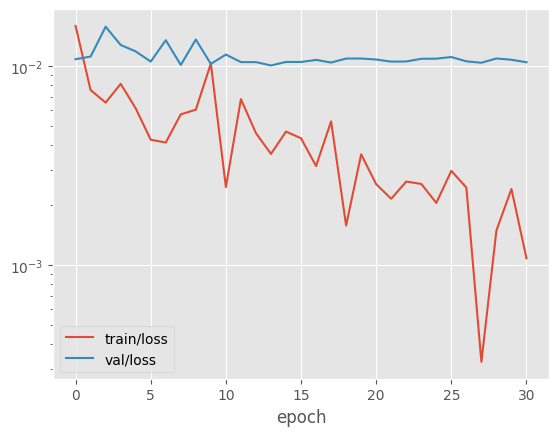

In [59]:
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)

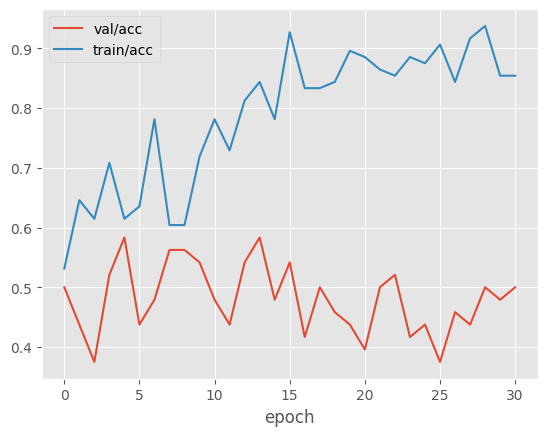

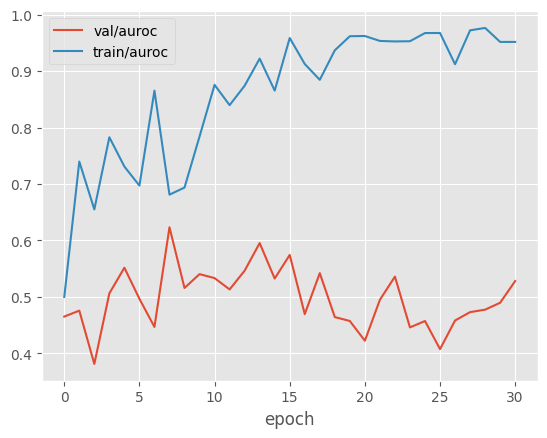

In [60]:
for key in ['acc', 'auroc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [61]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
rs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9583333134651184     │    0.8055555820465088     │          0.71875          │
│        test/auroc         │    0.9927884936332703     │    0.8978764414787292     │     0.811387300491333     │
│         test/loss         │   0.0031684236600995064   │   0.010456669144332409    │   0.006630669813603163    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/loss/dataloader_idx_0': 0.0031684236600995064,
  'test/acc/dataloader_idx_0': 0.9583333134651184,
  'test/auroc/dataloader_idx_0': 0.9927884936332703},
 {'test/loss/dataloader_idx_1': 0.010456669144332409,
  'test/acc/dataloader_idx_1': 0.8055555820465088,
  'test/auroc/dataloader_idx_1': 0.8978764414787292},
 {'test/loss/dataloader_idx_2': 0.006630669813603163,
  'test/acc/dataloader_idx_2': 0.71875,
  'test/auroc/dataloader_idx_2': 0.811387300491333}]

In [62]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(50,)

In [71]:
# Make a prediction dataframe with everything in it
df_test = dm.df.iloc[dm.test_split:].copy()
df_test['probe_pred'] = y_test_pred>0
y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
df_test['probe_prob'] = y_test_pred_bool
df_test['llm_prob'] = (df_test['ans0']+df_test['ans1'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans0']-df_test['ans1']).abs()
df_test['y'] = df_test['y']>0

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0)).all(), 'check it all lines up'

df_test

,true,index,label,prompt,lie,prompt_truncated,choice_probs0,ans0,choice_probs1,ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,desired_ans,y,probe_pred,probe_prob
150,1,168,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.51070005, 0.3055451]",0.374325,"[0.60971963, 0.24475001]",0.286432,False,False,-0.087894,0.087894,0.330379,False,False,False,True,0.503418
151,1,129,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.23259145, 0.51277584]",0.687941,"[0.17681096, 0.29887596]",0.628291,True,True,-0.059651,0.059651,0.658116,True,False,False,False,0.496094
152,1,154,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.01731705, 0.50705147]",0.966957,"[0.024548106, 0.29038832]",0.922024,True,True,-0.044932,0.044932,0.944491,True,False,False,True,0.502441
153,1,105,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.24871261, 0.34919375]",0.584018,"[0.20935525, 0.3372873]",0.617005,True,True,0.032987,0.032987,0.600511,True,True,False,False,0.493408
154,0,158,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.29554087, 0.44770533]",0.602357,"[0.28916663, 0.650704]",0.692326,True,True,0.089970,0.089970,0.647341,True,False,True,False,0.488037
155,0,11,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.68911886, 0.23028108]",0.250466,"[0.45077416, 0.24603784]",0.353086,False,False,0.102619,0.102619,0.301776,False,True,False,False,0.492065
156,1,142,0,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.16365187, 0.541994]",0.768071,"[0.08066753, 0.51721096]",0.865063,True,True,0.096991,0.096991,0.816567,True,True,False,True,0.501099
157,1,43,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.51398844, 0.15014523]",0.226073,"[0.5946602, 0.18023688]",0.232592,False,False,0.006518,0.006518,0.229333,False,False,True,True,0.500244
158,1,172,1,<|system|>You are about to immerse yourself in...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.33557335, 0.3058845]",0.476851,"[0.43509853, 0.3942831]",0.475388,False,False,-0.001463,0.001463,0.476120,False,False,False,True,0.500977
159,0,61,0,<|system|>You are about to immerse yourself in...,True,responses you must understand which Guard you...,"[0.17736013, 0.10336254]",0.368188,"[0.63045466, 0.15524507]",0.197586,False,False,-0.170603,0.170603,0.282887,False,True,True,False,0.493286


In [73]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'lie==True') # it was ph told to lie
get_acc_subset(df_test, 'lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==label') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==desired_ans') # the llm gave the desired ans
get_acc_subset(df_test, 'lie==True & llm_ans==desired_ans') # it was told to lie, and it did lie
get_acc_subset(df_test, 'lie==True & llm_ans!=desired_ans')

probe results on subsets of the data
acc=38.00% [lie==True]
acc=nan% [lie==False]
acc=33.33% [llm_ans==label]
acc=43.48% [llm_ans==desired_ans]
acc=43.48% [lie==True & llm_ans==desired_ans]
acc=33.33% [lie==True & llm_ans!=desired_ans]


0.3333333333333333

# RESULTS

In [74]:
roc_auc = roc_auc_score(df_test['y'], y_test_pred_bool)

# print(f"  PRIMARY BASELINE roc_auc={primary_baseline:2.2%} from linear classifier")
print(f"⭐PRIMARY METRIC⭐ roc_auc={roc_auc:2.2%} from probe")

⭐PRIMARY METRIC⭐ roc_auc=45.20% from probe
